In [8]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import RandomRotation
from keras import backend as K


# You will need to set this path according to where you've stored the data set on your machine!
filename = "/data/wbc/A3net/hack2/" + 'cluster_TNG_data.fits'
hdul = fits.open(filename)

image_size = hdul[1].data.shape[1]

train_ind = np.argwhere(hdul[2].data['train'] == 1)
train_X = hdul[1].data[train_ind].reshape(-1, image_size, image_size, 1)
train_Y = hdul[2].data['log_M500'][train_ind]

val_ind = np.argwhere(hdul[2].data['validate'] == 1)
val_X = hdul[1].data[val_ind].reshape(-1, image_size, image_size, 1)
val_Y = hdul[2].data['log_M500'][val_ind]

test_ind = np.argwhere(hdul[2].data['test'] == 1)
test_X = hdul[1].data[test_ind].reshape(-1, image_size, image_size, 1)
test_Y = hdul[2].data['log_M500'][test_ind]

norm = np.nanmin(hdul[2].data['log_M500'])
train_Y -= norm
val_Y -= norm
test_Y -= norm

input_shape = (image_size, image_size, 1)

In [13]:
model = Sequential()
model.add(RandomRotation(0.01, input_shape=input_shape, fill_mode='reflect'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(RandomRotation(0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(RandomRotation(0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 使用padding='same'来避免尺寸减少
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())#lr=0.0002

In [15]:
epochs = 100
batch_size = 16 #lower this value if you get a memory error
hist = model.fit(train_X, train_Y, validation_data = (val_X, val_Y), batch_size=batch_size, verbose=True, epochs=epochs)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 2079.3894 - val_loss: 3.3366
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 219.1677 - val_loss: 0.1662
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 45.5594 - val_loss: 0.1813
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 108.3642 - val_loss: 0.2373
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 41.6708 - val_loss: 0.0818
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 6.1480 - val_loss: 0.0712
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 4.2376 - val_loss: 0.2814
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 15.8365 - val_loss: 0.0921
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 2.7003 - val_loss: 0.0789
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 1.7190 - val_loss: 0.0557
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 2.7805 - val_loss: 0.1741
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 

0.006675188149020741


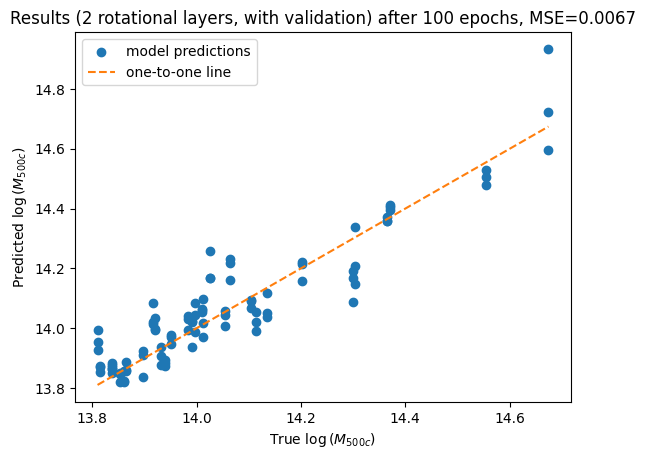

In [18]:
prediction = model.predict(test_X, verbose=0, batch_size=batch_size).flatten()
# Remember when we subtracted off the min in an earlier cell?  In the next line, we're putting it back in!

truevalue = test_Y + norm
predvalue = prediction + norm
truevalue = truevalue.flatten()

Ss = 0
for ts, ps in zip(truevalue, predvalue):
    Ss = Ss + (ts - ps)**2
MSE = Ss / len(truevalue)
print(MSE)

plt.scatter(test_Y + norm, prediction + norm, c='C0', label='model predictions')
x = np.linspace(np.min(test_Y+norm), np.max(test_Y+norm), 100)
plt.plot(x,x,ls='--', c='C1', label='one-to-one line')
plt.xlabel('True '+r'$\log\left(M_{500c}\right)$')
plt.ylabel('Predicted '+r'$\log\left(M_{500c}\right)$')
plt.title('Results (2 rotational layers, with validation) after {:.0f} epochs, MSE={:.4f}'.format(epochs, MSE))
plt.legend()

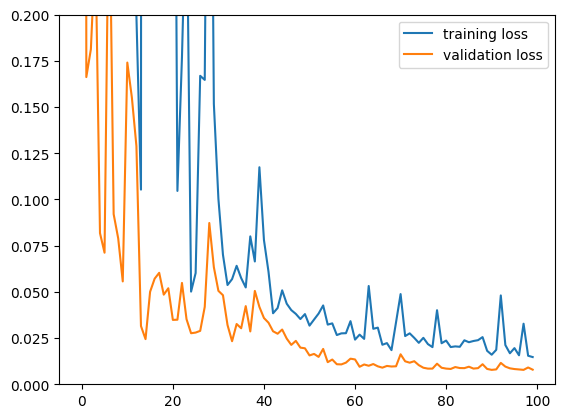

In [19]:
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.ylim(0,0.2)
plt.legend()